# KAN with ANS

Before executing the code below, following pre-requisites (in addition to the ones required for the evaluator package) are required.

In [16]:
%pip install pandas matplotlib numpy scikit-learn kan torch pyyaml tqdm  
%pip install ../dist/compression_evaluation-0.1.0-py3-none-any.whl --force-reinstall

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Processing c:\users\dell\documents\project\research\code\compression-algorithm-eval\dist\compression_evaluation-0.1.0-py3-none-any.whl
  Using cached memory_profiler-0.61.0-py3-none-any.whl.metadata (20 kB)
  Using cached numpy-2.3.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached psutil-7.1.0-cp37-abi3-win_amd64.whl.metadata (23 kB)
Using cached memory_profiler-0.61.0-py3-none-any.whl (31 kB)
Using cached numpy-2.3.3-cp312-cp312-win_amd64.whl (12.8 MB)
Using cached psutil-7.1.0-cp37-abi3-win_amd64.whl (247 kB)
  Attempting uninstall: psutil
    Found existing installation: psutil 7.1.0
    Uninstalling psutil-7.1.0:
      Successfully uninstalled psutil-7.1.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.3
    Uninstalling numpy-2.3.3:
      Successfully uninstalled numpy-2.3.3
  Attempting uninstall: memory-profiler
    Found existing installation: memory-profiler 0.61.0
    Uninstalling memory-profiler-0.61.0:
      Successfully uninstalled memor

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from kan.MultKAN import KAN
import compression_evaluation.methods as util_methods
import compression_evaluation.classes as util_classes
import compression_evaluation.types as util_types
import compression_evaluation.evaluator as util_evaluator

## Import datasets

Three datasets were used in this evaluation, all extracted from the Ariviyal Nagar weather station. Datasets accessible [here](https://www.ariviyalnagarweatherstation.org/Data.html).

From the dataset, three columns were used for this evaluation, which were extracted and isolated into seperate files for convenience. They were,
1. Solar Radition - A dataseries with a multi-modal (bimodal) distribution
2. Water Content - A dataseries with sudden rises and falls with mostly gradual fade
3. Air Temperature - A dataseries with mostly deterministic patterns with slight noise

In [18]:
air_temperature_df = pd.read_csv(r'..\datasets\AriviyalN_Data_Air_Temperature.csv')

extract dataseries,

In [19]:
air_temperature_column = air_temperature_df['Air Temperature']

## Inspect datasets

Basic data pre-processing

In [20]:
def print_invalids_count():
    print("Air Temperature NaNs:", air_temperature_column.isna().sum())

    print("Air Temperature Nulls:", air_temperature_column.isnull().sum())

def fill_with_mean(series):
    # Find indices where value is NaN or null
    nan_indices = series[series.isna() | series.isnull()].index
    for idx in nan_indices:
        prev_idx = idx - 1
        next_idx = idx + 1
        # Find previous non-null value
        while prev_idx >= 0 and (pd.isna(series.iloc[prev_idx]) or pd.isnull(series.iloc[prev_idx])):
            prev_idx -= 1
        # Find next non-null value
        while next_idx < len(series) and (pd.isna(series.iloc[next_idx]) or pd.isnull(series.iloc[next_idx])):
            next_idx += 1
        # If both indices are valid, fill with their mean
        if prev_idx >= 0 and next_idx < len(series):
            mean_val = (series.iloc[prev_idx] + series.iloc[next_idx]) / 2
            series.iloc[idx] = mean_val
    return series

# Before filling
print("Before cleanup: ")
print_invalids_count()

air_temperature_column = fill_with_mean(air_temperature_column)

# After filling
print("\nAfter cleanup: ")
print_invalids_count()

Before cleanup: 
Air Temperature NaNs: 0
Air Temperature Nulls: 0

After cleanup: 
Air Temperature NaNs: 0
Air Temperature Nulls: 0


Plot each dataseries to observe their continuity

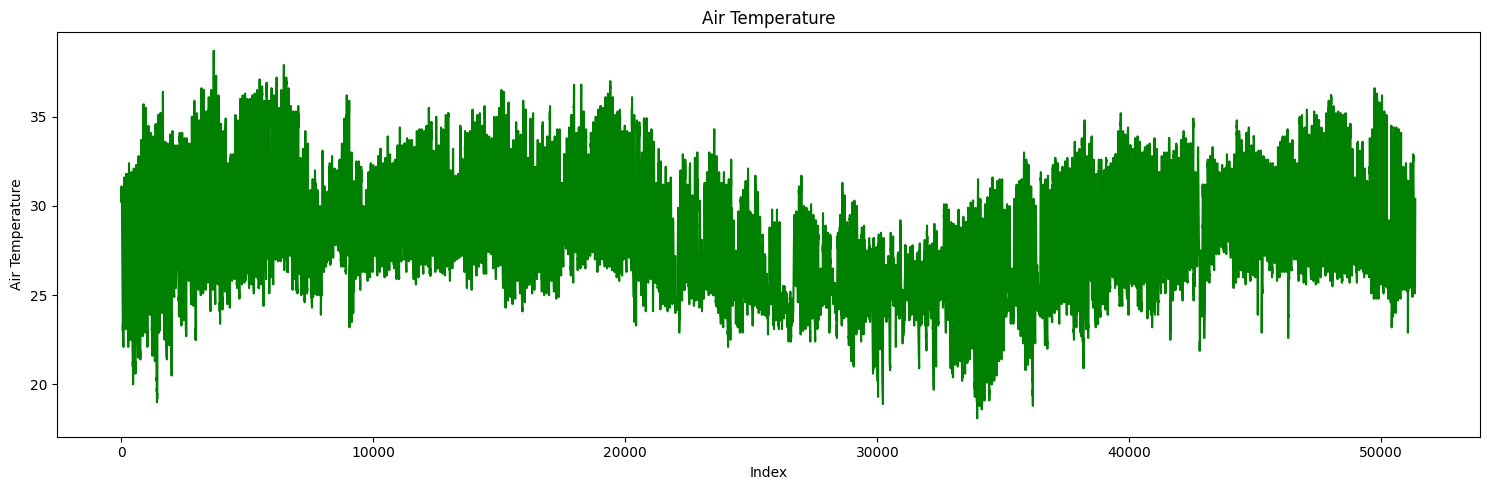

In [21]:
fig = plt.figure(figsize=(15, 5))

plt.plot(air_temperature_column, color='g')
plt.title('Air Temperature')
plt.ylabel('Air Temperature')
plt.xlabel('Index')

plt.tight_layout()
plt.show()

Plot and observe the dataset's value distribution

Completed Calculation of Air Temperature Histogram...


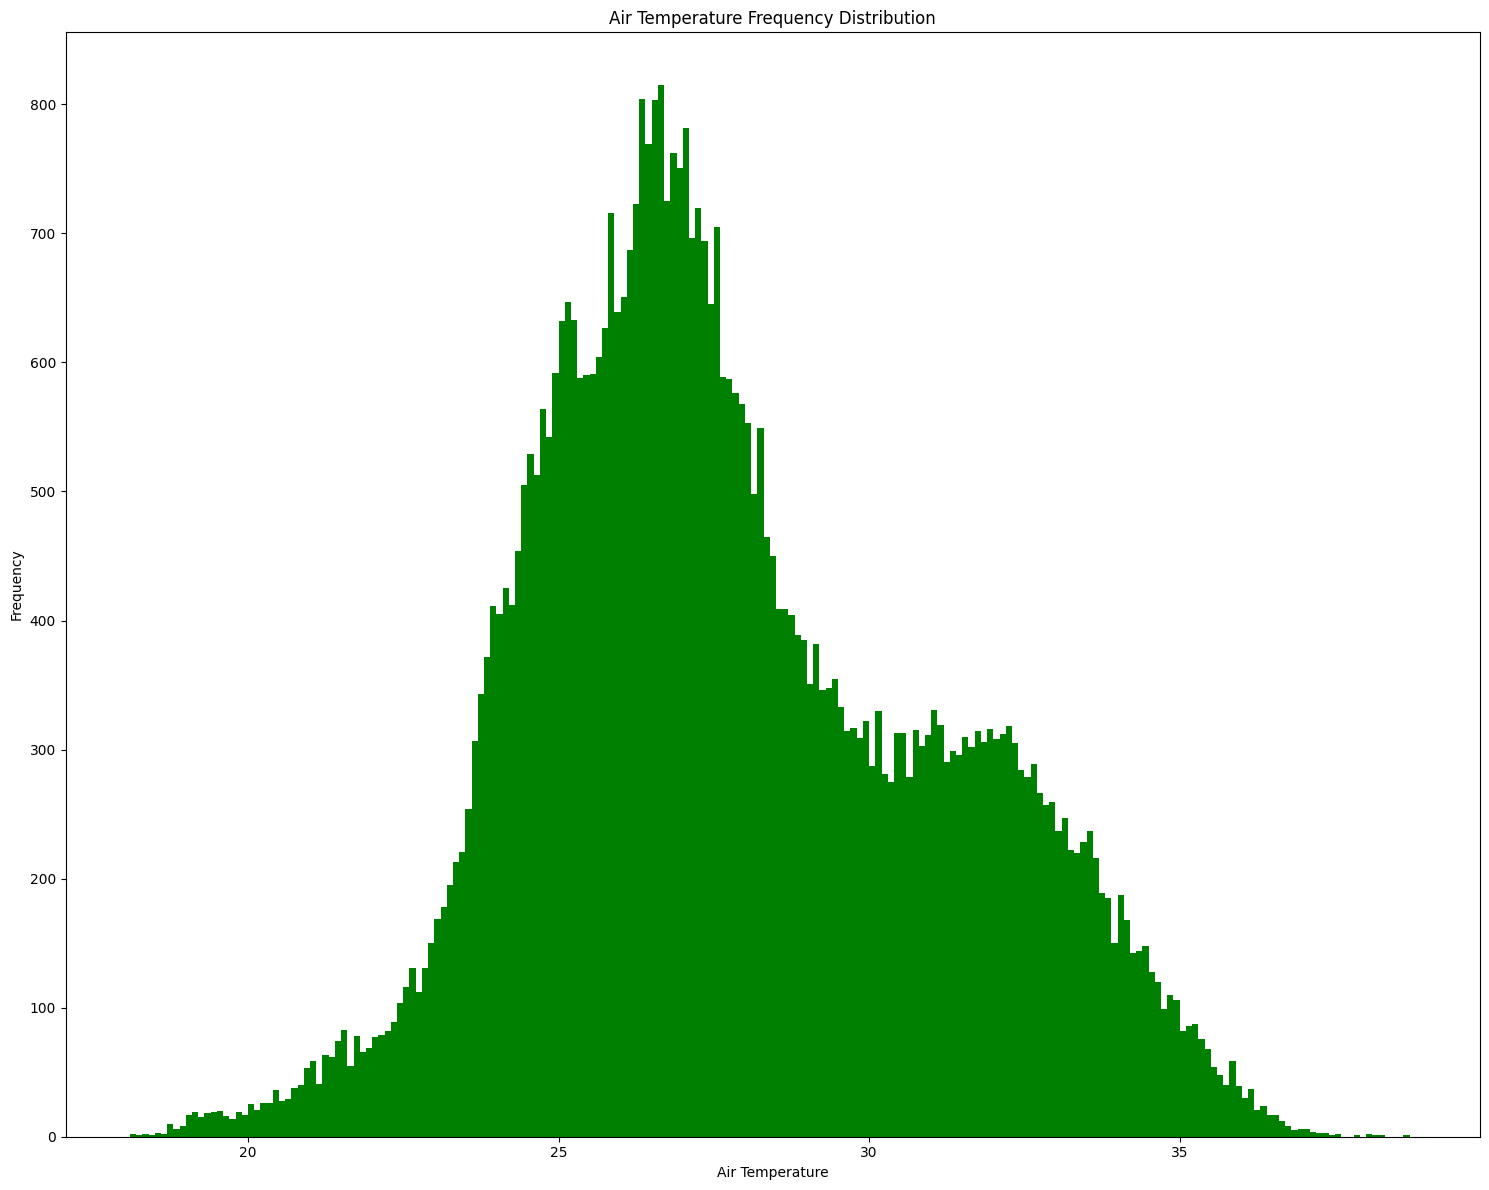

In [22]:
fig = plt.figure(figsize=(15, 12))

# Bin sizes
air_bin_size = 0.1

# Air Temperature
air_min, air_max = air_temperature_column.min(), air_temperature_column.max()
air_bins = np.arange(air_min, air_max + air_bin_size, air_bin_size)
plt.hist(air_temperature_column, bins=air_bins, color='g')
plt.title('Air Temperature Frequency Distribution')
plt.ylabel('Frequency')
plt.xlabel('Air Temperature')

print("Completed Calculation of Air Temperature Histogram...")

plt.tight_layout()
plt.show()


In [23]:
# Split training and testing sets

# Air temperature
air_temperature_training = air_temperature_column[:(len(air_temperature_column) * 9) // 10]
air_temperature_testing = air_temperature_column[(len(air_temperature_column) * 9) // 10:]


## Train Linear Predictor for optimum residuals

### For air temperature dataseries

Train linear regressors on air temperature dataset.

In [24]:
# split training dataeet into training and validating datasets
air_temperature_validating = air_temperature_training[(len(air_temperature_column) * 7) // 9:]
air_temperature_training = air_temperature_training[:(len(air_temperature_column) * 7) // 9]

In [25]:
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Prepare time series data
X_train_8_3, y_train_8_3 = util_methods.build_time_series_dataset(air_temperature_training, 8, 3)
X_valid_8_3, y_valid_8_3 = util_methods.build_time_series_dataset(air_temperature_validating, 8, 3, shuffle=False)

# Convert to PyTorch tensors
X_train_8_3 = torch.tensor(X_train_8_3, dtype=torch.float64, device=device)
y_train_8_3 = torch.tensor(y_train_8_3, dtype=torch.float64, device=device)

X_valid_8_3 = torch.tensor(X_valid_8_3, dtype=torch.float64, device=device)
y_valid_8_3 = torch.tensor(y_valid_8_3, dtype=torch.float64, device=device)

# Create dataset dictionary for KAN
dataset = {
    'train_input': X_train_8_3,
    'train_label': y_train_8_3,
    'test_input': X_valid_8_3,
    'test_label': y_valid_8_3
}

# Initialize KAN model
air_8_3_kan = KAN(width=[8, 5, 3], grid=1, k=1, seed=42, device=device)

# fit KAN model
air_8_3_kan.fit(dataset)

# Predict
y_train_8_3_pred = air_8_3_kan(dataset['train_input'])
y_valid_8_3_pred = air_8_3_kan(dataset['test_input'])

Using device: cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.74e-01 | test_loss: 4.94e-01 | reg: 2.61e+01 | : 100%|█| 100/100 [09:15<00:00,  5.55


saving model version 0.1


## Generate and record residuals

Using the trained predictors, residuals are generated to identify their distribution. This is done by building the complete Encoder without its Quantizer.

You might observe the residuals taking the form of laplace distributions.

### For air temperature dataseries

In [26]:
# Convert tensors to NumPy
air_bin_size = 0.1
train_label_np = dataset['train_label'].cpu().numpy()
y_train_8_3_pred_np = y_train_8_3_pred.detach().cpu().numpy()

test_label_np = dataset['test_label'].cpu().numpy()
y_valid_8_3_pred_np = y_valid_8_3_pred.detach().cpu().numpy()

# Compute residuals and round
residuals_8_3_train = np.round(train_label_np - y_train_8_3_pred_np, 1)
residuals_8_3_valid = np.round(test_label_np - y_valid_8_3_pred_np, 1)

# Compute MSE using torch or NumPy
mse_train = np.mean((residuals_8_3_train) ** 2)
mse_valid = np.mean((residuals_8_3_valid) ** 2)

print("MSE (train):", mse_train)
print("MSE (validation):", mse_valid)


MSE (train): 0.22574426525092656
MSE (validation): 0.24466166613469517


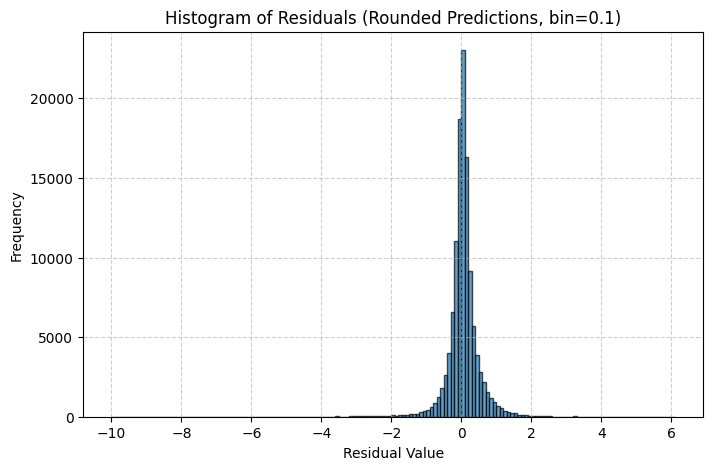

In [27]:
# generate bins to fit residuals (5 bin padding on either sides)
air_8_3_bins = np.arange(residuals_8_3_train.min() - 5 * air_bin_size, residuals_8_3_train.max() + 5 * air_bin_size, air_bin_size)

# get counts and bin edges
air_8_3_counts, air_8_3_bin_edges = np.histogram(residuals_8_3_train, bins=air_8_3_bins)
air_8_3_bin_centers = (air_8_3_bin_edges[:-1] + air_8_3_bin_edges[1:]) / 2

# plot histogram (reusing same bins)
plt.figure(figsize=(8, 5))
plt.bar(air_8_3_bin_centers, air_8_3_counts, width=air_bin_size, edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals (Rounded Predictions, bin=0.1)")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## Fit frequency tables for residuals

### For air temperature dataseries

In [ ]:
# input_dim = 8
# pad frequencies (given ANS considers symbols with 0 occurances are impossible)
air_8_3_padded_counts = air_8_3_counts + 1

# fit quantizer
air_8_3_quantizer = util_classes.UniformQuantizer(air_bin_size, len(air_8_3_bins), air_8_3_bin_edges[1], True)

# map bin centers to symbols
air_8_3_symbols = [air_8_3_quantizer.value_to_symbol(res) for res in air_8_3_bin_centers]

## Build complete encoder-decoder pair

### For air temperature dataseries

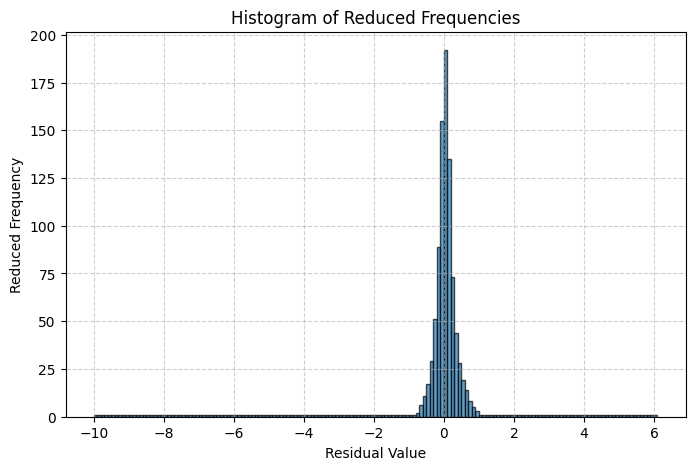

In [ ]:
# Trim frequencies to total sum
air_8_3_counts_trimmed = util_methods.largest_remainder_quantize(air_8_3_counts.tolist(), 1024)

# Plot reduced counts to observe shape
plt.figure(figsize=(8, 5))
plt.bar(air_8_3_bin_centers, air_8_3_counts_trimmed, width=air_bin_size, edgecolor='black', alpha=0.7)
plt.title("Histogram of Reduced Frequencies")
plt.xlabel("Residual Value")
plt.ylabel("Reduced Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Build a simple frequency table for ANS
air_8_3_freq_table = util_classes.SimpleFrequencyTable(air_8_3_counts_trimmed)

# Build ANS coder
air_8_3_ans = util_classes.ANSCoder(air_8_3_freq_table, air_8_3_quantizer)

class KANRegressorEnvelop(util_types.RegressorEnvelop):
    def predict(self, n, input_window):
        """
        n: number of steps to predict
        input_window: current input window of shape (input_size,)
        """
        assert input_window.shape[0] == 8, "Input window must match KAN input size"
        input_tensor = torch.tensor(input_window.reshape(1, -1), dtype=torch.float64, device=device)
        output = air_8_3_kan(input_tensor).cpu().detach().numpy().reshape(-1)
        return output[:n]


# Build static residual regressors with trained KAN
air_8_enveloped_regressor = KANRegressorEnvelop()
air_8_encoder_residual_regressor = util_classes.StaticResidualRegressor(air_8_enveloped_regressor, 8)
air_8_decoder_residual_regressor = util_classes.StaticResidualRegressor(air_8_enveloped_regressor, 8)

# Initialize sliding windows (adjust length according to your KAN input size)
air_8_encoder_residual_regressor._window = air_temperature_testing[0:8].to_numpy()
air_8_decoder_residual_regressor._window = air_temperature_testing[0:8].to_numpy()

# Build PC (predictive coding) encoder and decoder
air_8_tkan_encoder = util_classes.PCEncoder(air_8_encoder_residual_regressor, air_8_3_ans, air_8_3_quantizer, 3)
air_8_tkan_decoder = util_classes.PCDecoder(air_8_decoder_residual_regressor, air_8_3_ans, air_8_3_quantizer, 3)


## Evaluate encoder-decoder pair

### For air temperature dataseries

In [ ]:
# input dim = 8
# sample test
encoded = air_8_tkan_encoder.encode(air_temperature_testing[:50])
decoded = air_8_tkan_decoder.decode(encoded)
print("Original series:\t", air_temperature_testing[:50].to_list())
print("Reconstructed series:\t", np.round(np.array(decoded), 1).tolist())

air_8_evaluator = util_evaluator.Evaluator(air_8_tkan_encoder, air_8_tkan_decoder)

# evaluate with test dataset
print("\nEvaluation Metrics:")
air_8_evaluator.evaluate(air_temperature_testing[5:].to_numpy())

c:\Users\DELL\Documents\Project\Research\Code\compression-algorithm-eval\.venv\Lib\site-packages\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\DELL\Documents\Project\Research\Code\compression-algorithm-eval\.venv\Lib\site-packages\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\ReduceOps.cpp:1839.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\DELL\Documents\Project\Research\Code\compression-algorithm-eval\.venv\Lib\site-packages\kan\MultKAN.py:824: UserWarning: s

Original series:	 [27.5, 27.4, 27.3, 27.3, 27.3, 27.2, 27.1, 27.1, 27.1, 27.0, 26.9, 26.9, 26.9, 26.8, 26.8, 26.7, 26.7, 26.6, 26.6, 26.6, 26.6, 26.6, 26.5, 26.5, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.3, 26.3, 26.3, 26.5, 26.8, 27.0, 27.3, 27.7, 28.1, 28.5, 28.8, 29.3, 29.7, 30.2, 30.9, 31.2, 31.3, 31.9]
Reconstructed series:	 [27.5, 27.4, 27.3, 27.3, 27.3, 27.2, 27.1, 27.1, 27.1, 27.0, 26.9, 26.9, 26.9, 26.8, 26.8, 26.7, 26.7, 26.6, 26.6, 26.6, 26.6, 26.6, 26.5, 26.5, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.4, 26.3, 26.3, 26.3, 26.5, 26.8, 27.0, 27.3, 27.7, 28.1, 28.5, 28.8, 29.3, 29.7, 30.2, 30.9, 31.2, 31.3, 31.9]

Evaluation Metrics:


{'encode_time_sec': 15.887313100000028,
 'encode_mem_mb': 437.0703125,
 'decode_time_sec': 18.892339199999697,
 'decode_mem_mb': 436.9765625,
 'compression_ratio': 16.2373417721519,
 'bits_per_symbol': 3.941531865133502,
 'mse': np.float64(0.0008240665275963511),
 'snr_db': np.float64(60.12559408976725)}